# Notebook 6 — Dupire Local Volatility & Milstein Schemes

Dupire's formula extracts a **local-volatility surface** $\sigma_{\text{loc}}(S, t)$ from market-observed implied volatilities. Once calibrated, local vol can be used for:

- **Monte Carlo** simulation with Euler-Maruyama or **Milstein** discretisation
- **PDE pricing** via the finite-difference grid with node-dependent diffusion coefficients

This notebook demonstrates the full pipeline:

1. **Calibrate** an SVI implied-vol surface from synthetic market data
2. **Extract** the Dupire local-vol surface $\sigma_{\text{loc}}(S, t)$
3. **Visualise** the local-vol surface as a heatmap
4. **Price** with the FD solver using local vol
5. **Simulate** Milstein paths under local vol and price via MC
6. **Compare** Milstein (strong order 1.0) vs Euler-Maruyama (strong order 0.5)

**References**:
- Dupire, B. "Pricing with a Smile" (Risk, 1994)
- Duffy, D.J. *Numerical Methods in Computational Finance* (2022), ch. 24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

import optpricer as op
from optpricer.calibration import (
    fit_svi, fit_svi_surface, VolSurface,
    dupire_local_vol, dupire_local_vol_func,
)
from optpricer.pde import fd_price_local_vol
from optpricer.processes import local_vol_paths, milstein_local_vol_paths, gbm_milstein_paths

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

rng = np.random.default_rng(42)

## 1. Calibrate an SVI Surface

We create synthetic market IVs from a toy smile model, then calibrate the **SVI (Stochastic Volatility Inspired)** parametrisation slice-by-slice. SVI models the total variance as:

$$w(k) = a + b \left(\rho(k - m) + \sqrt{(k-m)^2 + \sigma^2}\right)$$

where $k = \ln(K/F)$ is the log-forward moneyness.

In [2]:
S0, r, q = 100.0, 0.05, 0.02
expiries = np.array([0.25, 0.5, 1.0, 2.0])
K_grid = np.linspace(70, 130, 25)

# Synthetic smile: parametric IV generator
def synthetic_iv(K, T, S0=100.0, r=0.05, q=0.02):
    F = S0 * np.exp((r - q) * T)
    k = np.log(K / F)
    base = 0.18 + 0.04 * np.sqrt(T)
    smile = 1.0 + 0.30 * np.abs(k) - 0.12 * k
    return np.maximum(0.05, base * smile)

# Generate market data
forwards = {T: S0 * np.exp((r - q) * T) for T in expiries}
strikes_by_T = {T: K_grid for T in expiries}
ivs_by_T = {T: synthetic_iv(K_grid, T) for T in expiries}

# Fit SVI surface (args: strikes_by_expiry, forwards, market_ivs_by_expiry)
surface = fit_svi_surface(strikes_by_T, forwards, ivs_by_T)

# Verify fit quality
for T in expiries:
    svi_ivs = surface.iv(K_grid, T)
    mkt_ivs = ivs_by_T[T]
    rmse = np.sqrt(np.mean((svi_ivs - mkt_ivs)**2))
    print(f"T = {T:.2f}y:  RMSE = {rmse:.6f}")

T = 0.25y:  RMSE = 0.000096
T = 0.50y:  RMSE = 0.000109
T = 1.00y:  RMSE = 0.000128
T = 2.00y:  RMSE = 0.000158


## 2. Extract the Dupire Local-Vol Surface

Dupire's formula in total-variance / log-moneyness coordinates:

$$\sigma_{\text{loc}}^2(K,T) = \frac{\partial w / \partial T}{1 - \frac{k}{w}\frac{\partial w}{\partial k} + \frac{1}{4}\left(-\frac{1}{4} - \frac{1}{w} + \frac{k^2}{w^2}\right)\left(\frac{\partial w}{\partial k}\right)^2 + \frac{1}{2}\frac{\partial^2 w}{\partial k^2}}$$

We use the analytical SVI derivatives $dw/dk$ and $d^2w/dk^2$ and a finite-difference approximation for $\partial w / \partial T$.

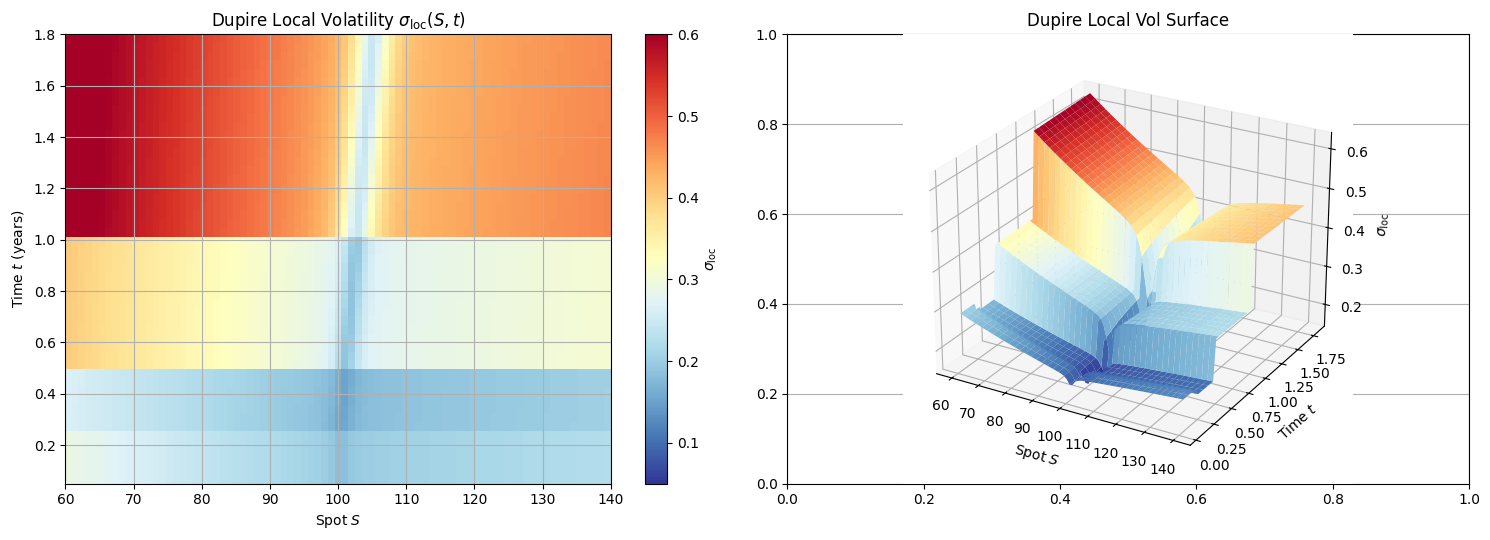

In [3]:
# Build the local-vol surface on a (S, t) grid
S_vals = np.linspace(60, 140, 81)
T_vals = np.linspace(0.05, 1.8, 51)

LV_surface = np.zeros((len(T_vals), len(S_vals)))
for i, t in enumerate(T_vals):
    LV_surface[i, :] = dupire_local_vol(surface, S_vals, t, r, q)

S_mesh, T_mesh = np.meshgrid(S_vals, T_vals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5.5))

# Heatmap
im = ax1.imshow(LV_surface, origin="lower", aspect="auto",
                extent=[S_vals.min(), S_vals.max(), T_vals.min(), T_vals.max()],
                cmap="RdYlBu_r", vmin=0.05, vmax=0.60)
ax1.set_xlabel(r"Spot $S$"); ax1.set_ylabel(r"Time $t$ (years)")
ax1.set_title(r"Dupire Local Volatility $\sigma_{\mathrm{loc}}(S, t)$")
fig.colorbar(im, ax=ax1, label=r"$\sigma_{\mathrm{loc}}$")

# 3D surface
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(S_mesh, T_mesh, LV_surface, cmap="RdYlBu_r", linewidth=0, antialiased=True)
ax2.set_xlabel(r"Spot $S$"); ax2.set_ylabel(r"Time $t$")
ax2.set_zlabel(r"$\sigma_{\mathrm{loc}}$")
ax2.set_title("Dupire Local Vol Surface")
ax2.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

The local-vol surface "absorbs" the market smile: regions where implied vol is high correspond to elevated local vol, and vice versa.

## 3. Local-Vol Pricing via FDM

The `fd_price_local_vol` function accepts a callable $\sigma(S, t)$ and uses it at each grid node and time step. We price calls across strikes and compare against constant-vol BS.

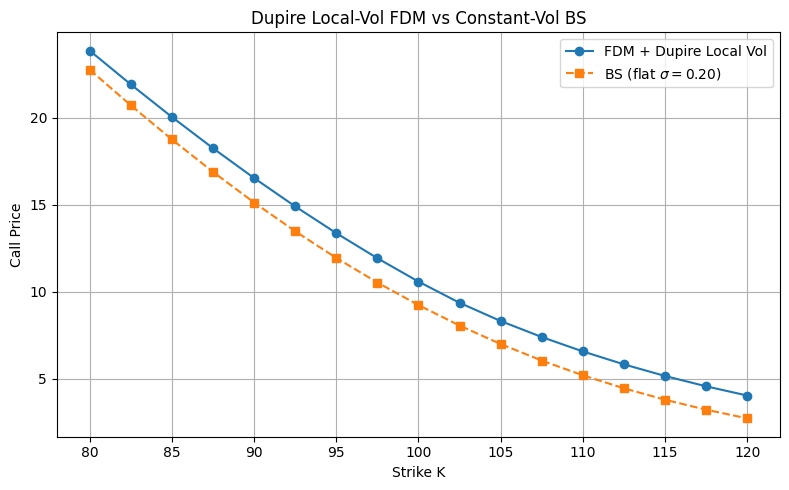

In [4]:
sigma_func = dupire_local_vol_func(surface, r, q)

strikes = np.linspace(80, 120, 17)
lv_fd_prices, bs_prices = [], []

for K in strikes:
    lv_p = fd_price_local_vol(S0, K, 1.0, r, q, sigma_func, op.CALL,
                              N_S=200, N_t=200, ref_vol=0.25)
    bs_p = op.bs_price(op.OptionSpec(S0=S0, K=K, T=1.0, r=r, sigma=0.20, q=q), op.CALL)
    lv_fd_prices.append(lv_p)
    bs_prices.append(bs_p)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(strikes, lv_fd_prices, "o-", label="FDM + Dupire Local Vol")
ax.plot(strikes, bs_prices, "s--", label=r"BS (flat $\sigma=0.20$)")
ax.set_xlabel("Strike K"); ax.set_ylabel("Call Price")
ax.set_title("Dupire Local-Vol FDM vs Constant-Vol BS")
ax.legend()
plt.tight_layout()
plt.show()

## 4. Milstein Scheme — Strong Order 1.0

The **Milstein scheme** adds a correction term to Euler-Maruyama that captures the curvature of the diffusion coefficient:

$$S_{n+1} = S_n + (r - q) S_n \Delta t + \sigma(S_n, t_n) S_n \sqrt{\Delta t}\, Z + \tfrac{1}{2} a(S_n) a'(S_n) (Z^2 - 1) \Delta t$$

where $a(S) = \sigma(S, t) \cdot S$ and $a'(S) = \partial a / \partial S$ is computed via **central finite differences**.

First, let's verify the constant-vol Milstein against exact GBM.

In [5]:
# Constant-vol Milstein: should match GBM mean
paths_mil = gbm_milstein_paths(S0=100, r=0.05, q=0.02, sigma=0.20,
                                T=1.0, n_steps=252, n_paths=50_000, seed=42)

expected_mean = S0 * np.exp((r - q) * 1.0)
actual_mean = paths_mil[-1].mean()

print(f"Expected E[S_T] = {expected_mean:.4f}")
print(f"Milstein  E[S_T] = {actual_mean:.4f}")
print(f"Relative error:    {abs(actual_mean - expected_mean) / expected_mean:.4%}")

Expected E[S_T] = 103.0455
Milstein  E[S_T] = 103.0543
Relative error:    0.0085%


## 5. Milstein Local-Vol Paths & MC Pricing

Now we combine the Dupire local-vol surface with the Milstein scheme to simulate paths and price options via Monte Carlo.

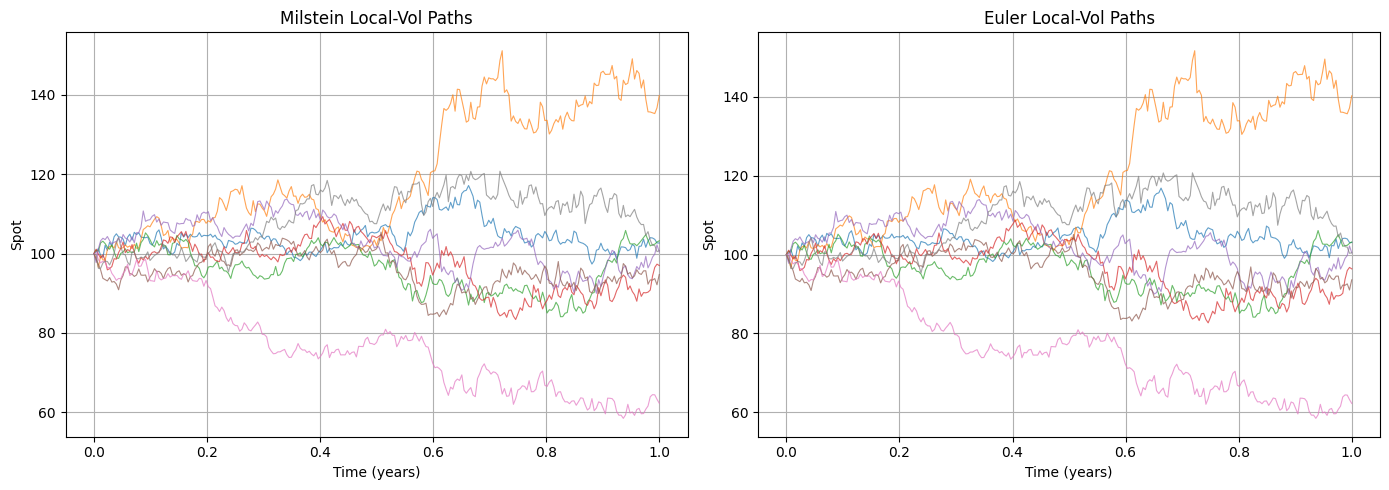

In [6]:
# Simulate Milstein local-vol paths
paths_lv_mil = milstein_local_vol_paths(
    S0=S0, r=r, q=q, T=1.0, n_steps=252, n_paths=50_000,
    sigma_loc=sigma_func, seed=42
)

# Also simulate Euler paths for comparison
paths_lv_euler = local_vol_paths(
    S0=S0, r=r, q=q, T=1.0, n_steps=252, n_paths=50_000,
    sigma_loc=sigma_func, seed=42
)

# Plot some sample paths
t_axis = np.linspace(0, 1.0, 253)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i in range(8):
    ax1.plot(t_axis, paths_lv_mil[:, i], alpha=0.7, linewidth=0.8)
ax1.set_xlabel("Time (years)"); ax1.set_ylabel("Spot")
ax1.set_title("Milstein Local-Vol Paths")

for i in range(8):
    ax2.plot(t_axis, paths_lv_euler[:, i], alpha=0.7, linewidth=0.8)
ax2.set_xlabel("Time (years)"); ax2.set_ylabel("Spot")
ax2.set_title("Euler Local-Vol Paths")

plt.tight_layout()
plt.show()

In [7]:
# MC pricing: Milstein vs Euler
disc = np.exp(-r * 1.0)
K_test = 100.0

ST_mil = paths_lv_mil[-1]
ST_euler = paths_lv_euler[-1]

mc_mil = disc * np.maximum(ST_mil - K_test, 0).mean()
mc_euler = disc * np.maximum(ST_euler - K_test, 0).mean()

# FDM local-vol price as reference
fd_ref = fd_price_local_vol(S0, K_test, 1.0, r, q, sigma_func, op.CALL,
                            N_S=400, N_t=400, ref_vol=0.25)

print(f"{'Method':<20} {'Price':>10} {'vs FDM':>10}")
print("-" * 42)
print(f"{'FDM (reference)':<20} {fd_ref:>10.4f} {'—':>10}")
print(f"{'MC Milstein':<20} {mc_mil:>10.4f} {abs(mc_mil - fd_ref):>10.4f}")
print(f"{'MC Euler':<20} {mc_euler:>10.4f} {abs(mc_euler - fd_ref):>10.4f}")

Method                    Price     vs FDM
------------------------------------------
FDM (reference)         10.5909          —
MC Milstein             10.5888     0.0021
MC Euler                10.6277     0.0367


## 6. Milstein vs Euler Convergence

The key advantage of Milstein over Euler-Maruyama is **strong order 1.0** vs 0.5. This means the path-level error decreases linearly with the time step $\Delta t$ (Milstein) versus as $\sqrt{\Delta t}$ (Euler).

We demonstrate this by computing the ATM call price at increasing step counts and measuring the difference from a fine-grid reference.

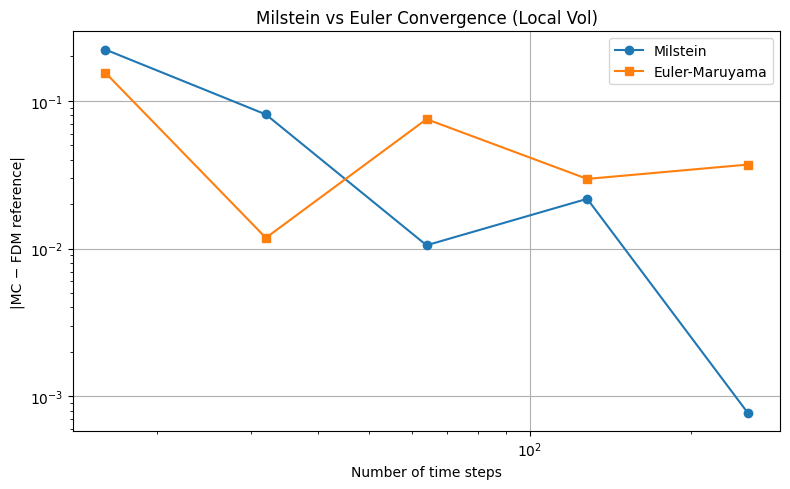

In [8]:
n_steps_list = [16, 32, 64, 128, 256]
n_paths = 80_000
K_conv = 100.0

# Reference: FDM price
ref_price = fd_price_local_vol(S0, K_conv, 1.0, r, q, sigma_func, op.CALL,
                               N_S=400, N_t=400, ref_vol=0.25)

mil_prices, euler_prices = [], []
for ns in n_steps_list:
    # Milstein
    p_mil = milstein_local_vol_paths(S0, r, q, 1.0, ns, n_paths, sigma_func, seed=42)
    mc_m = disc * np.maximum(p_mil[-1] - K_conv, 0).mean()
    mil_prices.append(mc_m)
    
    # Euler
    p_eul = local_vol_paths(S0, r, q, 1.0, ns, n_paths, sigma_func, seed=42)
    mc_e = disc * np.maximum(p_eul[-1] - K_conv, 0).mean()
    euler_prices.append(mc_e)

mil_errors = [abs(p - ref_price) for p in mil_prices]
euler_errors = [abs(p - ref_price) for p in euler_prices]

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(n_steps_list, mil_errors, "o-", label="Milstein")
ax.loglog(n_steps_list, euler_errors, "s-", label="Euler-Maruyama")
ax.set_xlabel("Number of time steps")
ax.set_ylabel("|MC − FDM reference|")
ax.set_title("Milstein vs Euler Convergence (Local Vol)")
ax.legend()
plt.tight_layout()
plt.show()

### Summary

This notebook demonstrated the full **Dupire local-vol pipeline**:

1. **Calibration**: SVI → implied-vol surface
2. **Extraction**: Dupire formula → local-vol surface $\sigma_{\text{loc}}(S,t)$
3. **Pricing**: Both PDE (FDM) and Monte Carlo (Milstein/Euler) consume the same callable

The Milstein scheme provides better strong-order convergence than Euler-Maruyama, which matters for path-dependent payoffs and greeks via pathwise differentiation.